In [1]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing
import ale_py

import torch
from torch import nn
from torch.distributions import Categorical

import cv2
import matplotlib.pyplot as plt
from collections import deque

import numpy as np

from ppo import PPO, DEVICE

In [2]:
gym.register_envs(ale_py)

env = gym.make("ALE/Breakout-v5", render_mode=None)
env = AtariPreprocessing(env, grayscale_obs=True, scale_obs=True, frame_skip=1, terminal_on_life_loss=True)

In [3]:
def preprocess_obs(obs, crop_top=18):
    obs = cv2.resize(obs, (84, 110))
    return obs[crop_top: crop_top + 84, :]

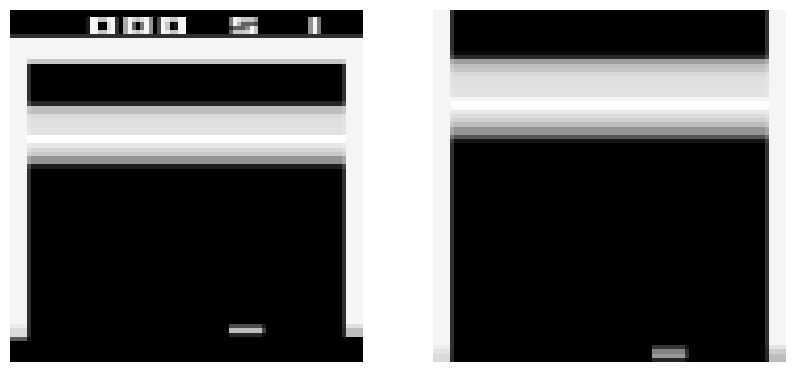

(84, 84) (84, 84)


In [4]:
obs, info = env.reset()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(obs, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocess_obs(obs), cmap='gray')
plt.axis('off')

plt.show()

print(obs.shape, preprocess_obs(obs).shape)

In [5]:
K = 15
total_frames = 1_000_000_000
max_ep_frames = 20_000
policy_update_freq = 100

In [6]:
ppo = PPO()

In [ ]:
frame = 0
num_episodes = 0

max_reward = -float('inf')

ACTION_MAP = [0, 2, 3]  # NOOP, LEFT, RIGHT

while frame < total_frames:
    env.reset()
    env.step(1)  # FIRE
    obs, _, _, _, _ = env.step(1)  # FIRE

    frame_stack = deque([preprocess_obs(obs)] * 4, maxlen=4)

    ep_reward = 0

    for _ in range(max_ep_frames):
        action_idx = ppo.get_action(np.array(frame_stack))

        action = ACTION_MAP[action_idx]
        obs, reward, terminated, truncated, info = env.step(action)

        reward -= 0.01  # time penalty
        done = terminated or truncated
        
        if done:
            reward -= 1.0  # penalty for losing the game

        frame_stack.append(preprocess_obs(obs))

        ppo.add_reward(reward, done)

        ep_reward += reward
        frame += 1
        
        if done:
            break
        
    if num_episodes % policy_update_freq == 0:
        print("Training...")
        print(f"Buffer size: {len(ppo.buffer['rewards'])} frames")

        ppo.entropy_coeff = max(0.01, 0.1 - (num_episodes / 10000) * 0.01)      
        ppo.update(K=K)

        torch.save(ppo.policy.state_dict(), f"models/model_{num_episodes}.pth")
        print(f"Saved model at episode {num_episodes} frame {frame}")

    if ep_reward >= max_reward:
        torch.save(ppo.policy.state_dict(), f"models/best_model.pth")
        max_reward = ep_reward
        
    num_episodes += 1

    if num_episodes % 10 == 0:
        print(f"Episode {num_episodes} Frame: {frame} Episode Reward: {ep_reward:.3f} Max Reward: {max_reward:.3f} Entropy Coeff: {ppo.entropy_coeff:.3f}")

Training...
Buffer size: 23 frames
Saved model at episode 0 frame 23
Episode 10 Frame: 314 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 20 Frame: 601 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 30 Frame: 951 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 40 Frame: 1181 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 50 Frame: 1487 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 60 Frame: 1791 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 70 Frame: 2022 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 80 Frame: 2301 Episode Reward: -1.230 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 90 Frame: 2587 Episode Reward: -0.510 Max Reward: -0.510 Entropy Coeff: 0.100
Episode 100 Frame: 2904 Episode Reward: -1.230 Max Reward: 0.180 Entropy Coeff: 0.100
Training...
Buffer size: 2904 frames
Saved model at episode 100 frame 2927